In [1]:
# Notebook for isolating triggers and releases

# Load data
import numpy as np
import matplotlib.pyplot as plt

# Width of triggers 
width = 32
fileName = "second_collection"
data = np.load((fileName+".npz"))

In [2]:
# Find signal triggers
def findTrigIdxs(signal):
    """
    Finds the indexes of the signal where the trigger happens
    """

    mask = signal <= 0.2 
    mask = mask[:, np.newaxis]
    zerosIdx = np.argwhere(mask)[:, 0].astype(int)        # zeros in the signal
    jumpIdx = np.argwhere(np.diff(zerosIdx)>1)[:, 0].astype(int)   # Non-consecutive zeros
    trigIdx =  zerosIdx[jumpIdx].astype(int)
    # TODO: Huge mistake when selecting releases!
    # If using threshold, will select release up until threshold
    releaseIdx = zerosIdx[jumpIdx+1].astype(int)
    return trigIdx, releaseIdx


def separateIntoTriggers(signal, trigIdx, releaseIdx, width=width):
    triggers = []
    releases = []
    for i, j in zip(trigIdx, releaseIdx):
        upSig = signal[i:i+width]
        if np.any(upSig>=2):
            triggers.append(upSig) 
        downSig = signal[j-width:j]
        releases.append(downSig)
    return np.array(triggers), np.array(releases) 


def plotTriggers(triggers, nx_plots=10, ny_plots=2):
    plt.figure(figsize=(nx_plots*2, ny_plots*2))
    for i in range(nx_plots * ny_plots):
        plt.subplot(ny_plots, nx_plots, i+1)
        trig = triggers[i]
        plt.plot(range(len(trig)), trig, "b.")
        plt.xticks([])


def plotSignal(signal, upTo):
    plt.figure(figsize=(30, 5))
    signal = signal[:upTo]
    plt.plot(range(len(signal)), signal, "b.")
    plt.show()

Signal shape: (899996,)


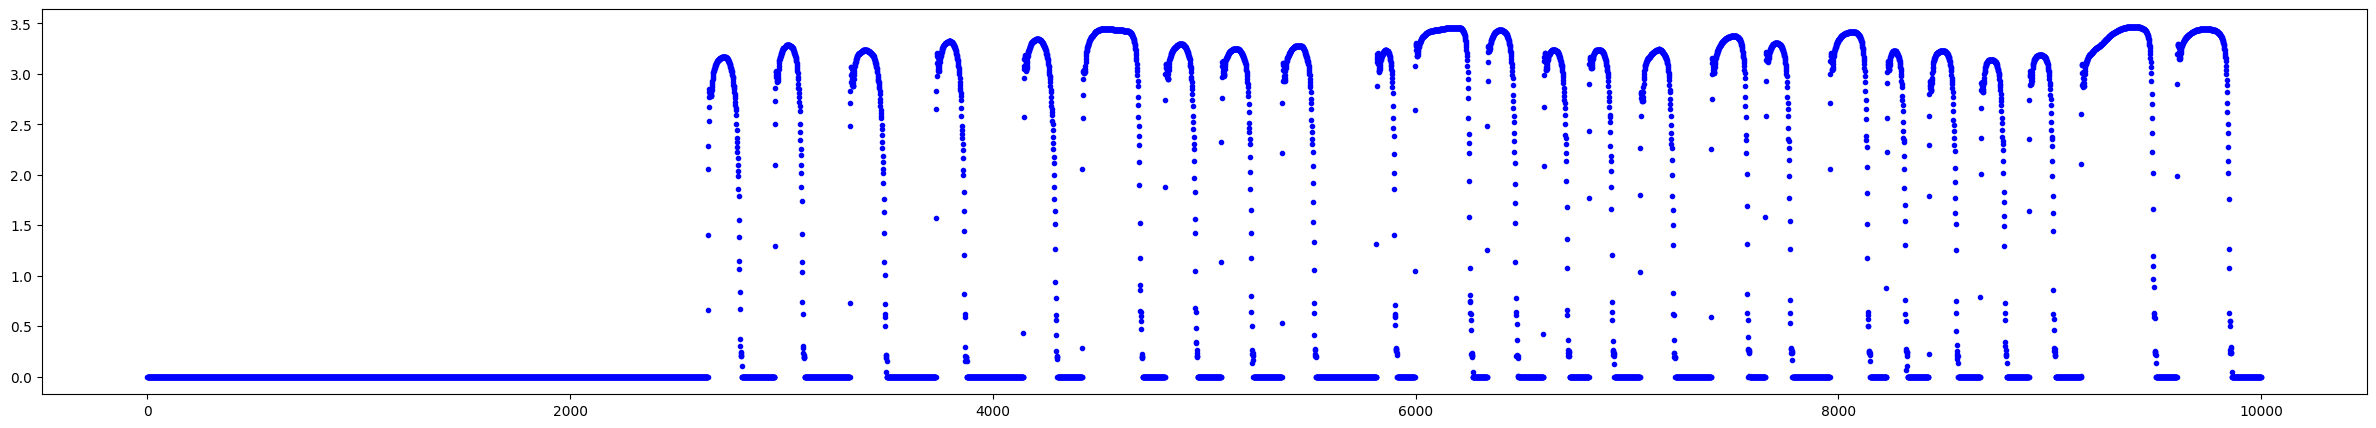

triggers shape: (2259, 32)
releases shape:  (3317, 32)


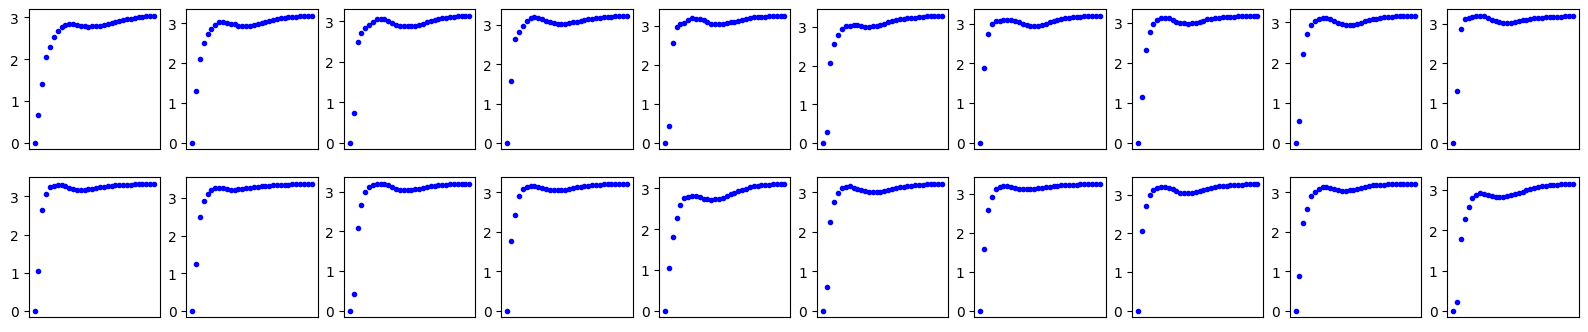

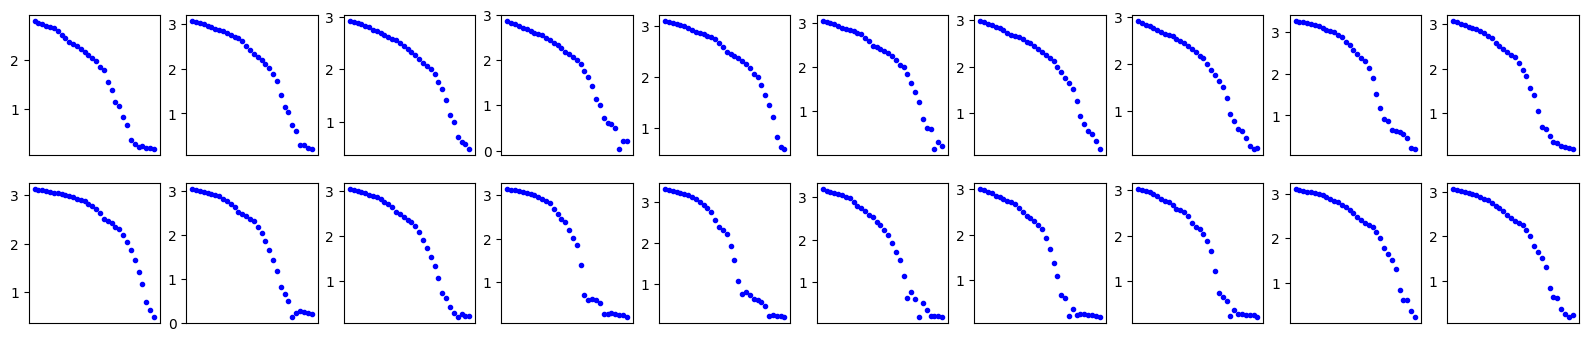

In [3]:
# Look at a few triggers of one of the users
key = "A"
signal = data[key]   # Only a few presses 
print("Signal shape:", signal.shape)
plotSignal(signal, upTo=10000)
trigIdx, relIdx = findTrigIdxs(signal)
triggers, releases = separateIntoTriggers(signal, trigIdx, relIdx)
print("triggers shape:", triggers.shape)
print("releases shape: ", releases.shape)
plotTriggers(triggers) 
plotTriggers(releases)

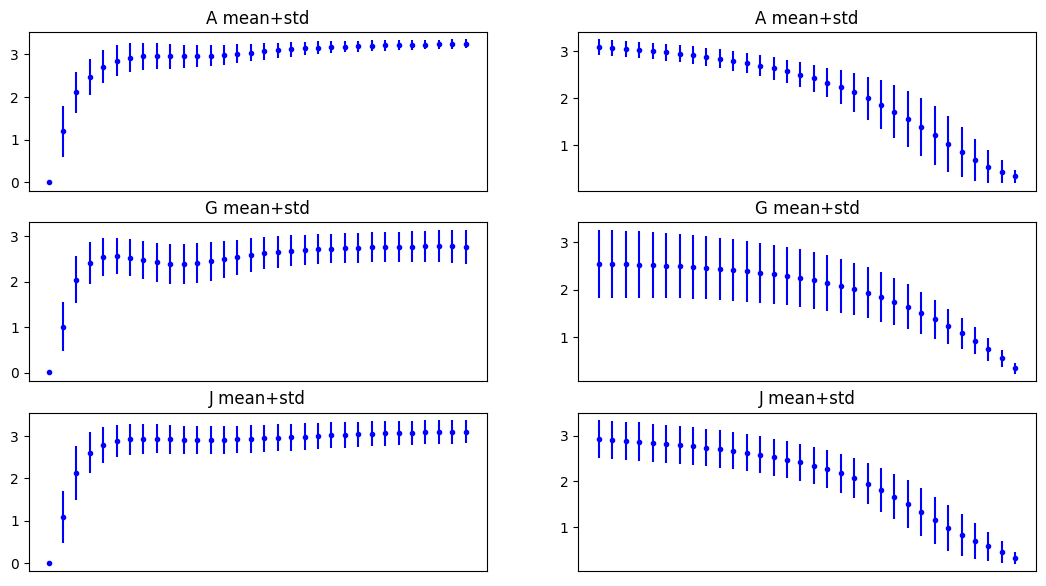

In [4]:
# Compare the mean and std of the signals for all the users involved
plt.figure(figsize=(13, 7))
n_users = len(data)
for i, key in enumerate(data):
    trigIdx, relIdx = findTrigIdxs(data[key])
    triggers, releases = separateIntoTriggers(data[key], trigIdx, relIdx)
    for j, sig in enumerate([triggers, releases]):
        plt.subplot(n_users, 2, 2*i+j+1)
        sigAvg = np.mean(sig, axis=0)
        sigStd = np.std(sig, axis=0)
        plt.title(key+" mean+std")
        plt.errorbar(np.arange(len(sigAvg)), sigAvg, sigStd, fmt="b.")
        plt.xticks([])

In [5]:
# Loop to build and save data 
# Only run if want to update saved file 
filteredData = {}
for key in data:
    signal = data[key].flatten()
    trigIdx, relIdx = findTrigIdxs(signal)
    triggers, releases = separateIntoTriggers(signal, trigIdx, relIdx)
    filteredData[key+"_triggers"] = triggers
    filteredData[key+"_releases"] = releases 
    print(f"saving {key}_triggers: ", triggers.shape)
    print(f"saving {key}_releases: ", releases.shape)

output = fileName + "_triggs_rels" + f"_{triggers.shape[1]}.npz"
np.savez(output, **filteredData)

saving A_triggers:  (2259, 32)
saving A_releases:  (3317, 32)
saving G_triggers:  (2694, 32)
saving G_releases:  (3077, 32)
saving J_triggers:  (2545, 32)
saving J_releases:  (3197, 32)
